코드 출처 : https://github.com/rickiepark/handson-ml

스터디 발표를 위해 역자 코드를 바탕으로 내용을 추가하였습니다.

In [22]:
# pip install ipython
# pip install jupyter
# pip install tensorflow

In [23]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.6.4
IPython 6.2.1

numpy 1.14.0
sklearn 0.19.1
scipy 1.0.0
matplotlib 2.1.2
tensorflow 1.5.0


# 11장 – 심층 신경망 훈련**

신경망 시각화 [참조]( http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.66315&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

_이 노트북은 11장에 있는 모든 샘플 코드를 가지고 있습니다._

심층 신경망 구현의 3가지 주요 문제    

1) 그래디언트 소실(폭주 문제)    

2) 훈련이 느려지는 문제    

3) 과적합    



# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [24]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력 mac
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

#한글출력 window
# plt.rcParams['font.family'] = 'NanumBarunGothic'
# plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# 그래디언트 소실/폭주 문제

오차 함수의 그래디언트가 경사하강법 단계의 파라미터 수정 단계에서 점점 작아져서 가중치가 변경되지 않는 문제

Xavier Glorot와 Yoshua Bengio의 [관련 논문](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)참조

로지스틱 활성화 함수를 보면 아래 그림 처림 절댓값이 0이나 1로 수렴해서 기울기가 0에 매우 가까워지는 것을 볼 수 있다. 그래서 역전파가 될 때 사실상 신경망으로 전파시킬 그래디언트가 거의 없고 조금 있는 그래디언트는 최상위에서부터 역전파가 진행됨에 따라 점점 약해져서 실제로 아래층에 도달시킬 것이 없게 됩니다.

In [25]:
def logit(z):
    return 1 / (1 + np.exp(-z))

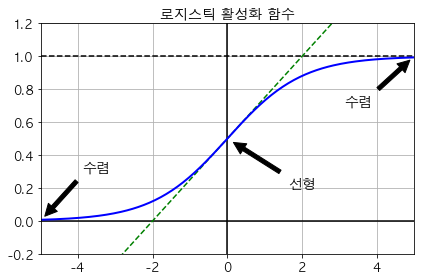

In [26]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('수렴', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('수렴', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('선형', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("로지스틱 활성화 함수", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier와 He 초기화

세이비어 초기화 메인 아이디어: 마이크 볼륨이 0에 가까우면 안들리고 반대로 최대치면 너무 시끄러워서 무슨 말인지 모르게 됩니다. 잘 들리려면 모든 증폭기가 적절하게 설정하기 위해서는 입력 목소리이 크기와 출력 목소리의 크기와 같도록 적절하게 설정해야 할 것입니다. 
이처럼 입력층의 분산과 출력층의 분산이 같도록 하는 것.     

연결 가중치를 다음 식과 같이 무작위로 초기화 하여 작동하도록 하는 방식으로 여기서 n <sub>inputs</sub> 와 n <sub>outputs</sub>  는 가중치를 초기화하려는 층의 입력과 출력 연결의 개수입니다. 
 


xavier - 입력값과 출력값 사이의 난수를 선택해서 입력값의 제곱근으로 나눕니다.    


$$
σ = 1/\sqrt n ~inputs~
$$



he - 입력값을 반으로 나눈 제곱근 사용. 분모가 작아지기 때문에 xavier보다 넓은 범위의 난수 생성.

In [27]:
import tensorflow as tf

In [28]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X") 

#형태(shape)를 정의하고 None 을 이용하여 임의의 batch size를 핸들링

데이터 로드 : MNIST는 greyscale인 손글씨 이미지를 보고 1에서 9까지 숫자 중 어떤 것인지 맞추는 데이터입니다. 
28x28 픽셀 이미지로 되어 있습니다.

<img src = "mnist.png", width = "500"><BR>

[데이터 시각화 참조](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)

In [29]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

텐서플로에서는 변수를 생성하는 함수로 `get_variable()`이나  `tf.layers.dense()`를 제공합니다. 

## 수렴하지 않는 활성화 함수

<img src = "sig_01.jpeg", width="500"><BR>

<img src = "sig_02.jpeg", width="500"><BR>

### Leaky ReLU

ReLU 정의 : <p>$$f(x)=max(0,x)$$</p>

x가 양수이기만 하면 그래디언트는 1 로 일정

ReLu함수는 입력이 음수면 그래디언트가 0이 되기 때문에 일부 뉴런이 0이외의 값을 출력하지 않는 문제가 생겼습니다. 

Leaky ReLU 정의 : <p>$$f(x)=max(0.01x,x)$$</p>
x가 음수일 때 그래디언트가 0.01

In [30]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

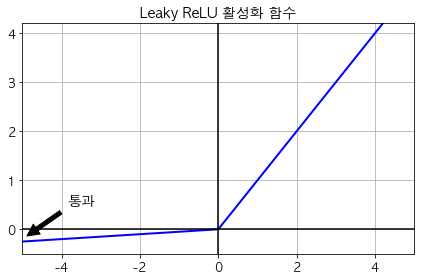

In [31]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('통과', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU 활성화 함수", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

텐서플로에서 Leaky ReLU 구현하기:

_텐서플로 1.4에서 tf.nn.leaky_\__relu(z, alpha) 함수가 추가되었습니다._

In [32]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [33]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Leaky ReLU를 사용하여 신경망을 훈련시켜 보죠. 

## 먼저 그래프를 정의합니다:

In [34]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [35]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [36]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [37]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

### softmax

<img src = "softmax.png", width="800"><BR>

이미지 [출처](https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/mnist/beginners/)

In [38]:
learning_rate = 0.01

#학습 비율 0.01로 경사하강법을 써서 cross_entropy를 줄여주고 텐서플로우에서는 경사하강의 그래프 추가함
#Optimizer : 모델이 loss(predictions 와 labels 사이의 차이)를 최소화 하는 방향으로 파라미터 업데이트

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)



In [39]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

saver로 전체 매개변수 변수 초기화하여 가중치(weight)와 편향(bias)를 정의 

In [40]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## 데이터 로드

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [41]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

이미지 데이터는 [image index, pixel index] 형태의 이차원 텐서(여기선 2차원 배열을 의미함)로 추출될 수 있습니다. 각 엔트리는 특정 이미지에서 특정 픽셀의 휘도값(Luminance)이며, [0, 255]에서 [0, 1]까지 재조정됩니다 


[참조](https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/mnist/download/)

## 배치 

매 단계마다 전체 데이터를 사용할 수 없으므로 무작위 데이터를 사용하여 graph 에 feed 

In [42]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [43]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/")

In [44]:
n_epochs = 40
batch_size = 50

#반복되는 루프마다 학습 데이터셋을 무작위로 50개씩 가져옵니다.

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 배치 데이터 정확도: 0.86 검증 세트 정확도: 0.9046
5 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9496
10 배치 데이터 정확도: 0.92 검증 세트 정확도: 0.9654
15 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9708
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9764
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9774
30 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.978
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9784


### ELU

Exponential Linear Units 

<p>$$ f(x)=x   \      \                   if\        x>0  $$</p>

<p>$$ f(x)=α(e^x −1) \      \      if\        x≤0 $$</p>

In [45]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

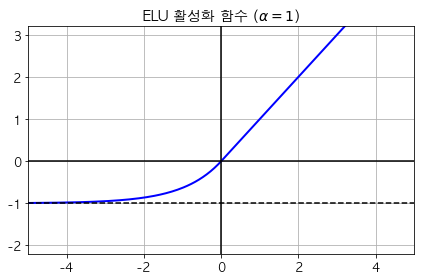

In [46]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU 활성화 함수 ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

텐서플로에서 ELU를 구현하는 것은 간단합니다. 층을 구성할 때 활성화 함수에 지정하기만 하면 됩니다:

In [47]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [48]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

Self-Normalizing Neural Networks : 이 활성화 함수는 Günter Klambauer, Thomas Unterthiner, Andreas Mayr가 2017년에 쓴 [논문](https://arxiv.org/pdf/1706.02515.pdf)에서 소개되었습니다. 훈련할 때 SELU 활성화 함수를 사용한 완전 연결 신경망은 스스로 정규화를 합니다. 각 층의 출력은 훈련하는 동안 같은 평균과 분산을 유지하려는 경향이 있어 그래디언트 소실과 폭주 문제를 해결합니다. 이 활성화 함수는 심층 신경망에서 다른 활성화 함수보다 뛰어난 성능을 내므로 꼭 이 함수를 시도해봐야 합니다.

<img src="selu.png" width="500"><BR>

In [49]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

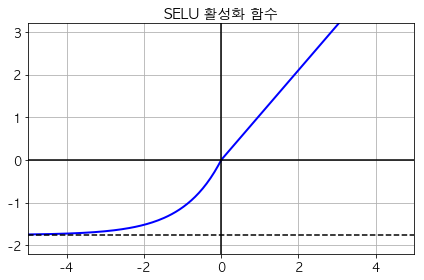

In [50]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU 활성화 함수", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

기본적으로 SELU 하이퍼파라미터(`scale`과 `alpha`)는 평균이 0, 표준 편차가 1에 가깝게 유지되도록 조정합니다(입력도 평균이 0, 표준 편차가 1로 표준화되었다고 가정합니다). 이 활성화 함수를 사용하면 100층으로 된 심층 신경망도 그래디언트 소실/폭주 문제없이 모든 층에서 대략 평균이 0이고 표준 편차가 1을 유지합니다:

In [51]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("층 {}: {:.2f} < 평균 < {:.2f}, {:.2f} < 표준 편차 < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

층 0: -0.26 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 10: -0.24 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 20: -0.17 < 평균 < 0.18, 0.74 < 표준 편차 < 1.24
층 30: -0.27 < 평균 < 0.24, 0.78 < 표준 편차 < 1.20
층 40: -0.38 < 평균 < 0.39, 0.74 < 표준 편차 < 1.25
층 50: -0.27 < 평균 < 0.31, 0.73 < 표준 편차 < 1.27
층 60: -0.26 < 평균 < 0.43, 0.74 < 표준 편차 < 1.35
층 70: -0.19 < 평균 < 0.21, 0.75 < 표준 편차 < 1.21
층 80: -0.18 < 평균 < 0.16, 0.72 < 표준 편차 < 1.19
층 90: -0.19 < 평균 < 0.16, 0.75 < 표준 편차 < 1.20


텐서플로 1.4 버전에 `tf.nn.selu()` 함수가 추가되었습니다. 이전 버전을 사용할 때는 다음 구현을 사용합니다:

In [52]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

하지만 SELU 활성화 함수는 일반적인 드롭아웃과 함께 사용할 수 없습니다(드롭아웃은 SELU 활성화 함수의 자동 정규화 기능을 없애버립니다). 다행히 같은 논문에 실린 알파 드롭아웃(Alpha Dropout)을 사용할 수 있습니다. 텐서플로 1.4에 `tf.contrib.nn.alpha_dropout()`이 추가되었습니다(Linz 대학교 생물정보학 연구소(Institute of Bioinformatics)의 Johannes Kepler가 만든 [구현](https://github.com/bioinf-jku/SNNs/blob/master/selu.py)을 확인해 보세요).

SELU 활성화 함수를 사용한 신경망을 만들어 MNIST 문제를 풀어 보겠습니다:

In [53]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

## 이제 훈련할 차례입니다. 

입력을 평균 0, 표준 편차 1로 스케일 조정해야 합니다:

In [54]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 배치 데이터 정확도: 0.88 검증 세트 정확도: 0.923
5 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9574
10 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9662
15 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.9682
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9692
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9688
30 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9694
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.97


# 배치 정규화

ELU와 함께 HE 초기화를 사용하면 훈련 초기 단계에서는 그래디언트 소실문제가 크게 줄어들지만 훈련하는 동안 그 문제가 다시 발생하지 않으리란 보장이 없습니다. 좀 더 일반적인 설명으로는 훈련하는 동안 이전 층의 파라미터가 변함에 따라 각 층에 들어오는 입력의 분포가 변하는 문제(내부 공변량 변화 문제)입니다. 이를 해결하기 위해 Sergey Ioffe와 Christian Szegedy의 [논문](https://arxiv.org/pdf/1502.03167v3.pdf)에서 배치 정규화를 제안하고 있습니다.

각 은닉층의 활성화 함수 전에 배치 정규화를 추가하기 위해 ELU 활성화 함수를 배치 정규화 층 이후에 수동으로 적용하겠습니다.

노트: `tf.layers.dense()` 함수가 (책에서 사용하는) `tf.contrib.layers.arg_scope()`와 호환되지 않기 때문에 대신 파이썬의 `functools.partial()` 함수를 사용합니다. 이를 사용해 `tf.layers.dense()`에 필요한 매개변수가 자동으로 설정되도록 `my_dense_layer()`를 만듭니다(그렇지 않으면 `my_dense_layer()`를 호출할 때마다 덮어씌여질 것입니다). 다른 코드는 이전과 비슷합니다.

In [55]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

#placeholder()함수는 첫번째 매개변수로 데이터 타입을 넘겨받고 
#placeholder_with_default()함수로 첫 번째 매개변수로 플레이스홀더의 기본값을 넘겨받습니다.
#traing하는 동안은 True로 그 외에는 False로 설정합니다.
training = tf.placeholder_with_default(False, shape=(), name='training')

#tf.layers.batch_normalization()함수가 훈련할 때 현재 미니배치의 평균과 표준편차를 사용할 지 
#또는 테스트할 때 전체 훈련 세트에 대한 평균과 표준편차를 사용할 지 지정합니다.
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

#적절한 momentum값는 일반적으로 1에 가깝습니다. 예를 들면 0.9, 0.99, 0.999입니다.
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)


logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [56]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

같은 매개변수를 계속 반복해서 쓰지 않도록 파이썬의 `partial()` 함수를 사용합니다:

In [57]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

각 층에 ELU 활성화 함수와 배치 정규화를 사용하여 MNIST를 위한 신경망을 만듭니다:

In [58]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

노트: 배치 정규화를 위해 별도의 업데이트 연산을 실행해 주어야 합니다(`sess.run([training_op, extra_update_ops],...`).

In [59]:
n_epochs = 20
batch_size = 200

In [60]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9042
1 검증 세트 정확도: 0.928
2 검증 세트 정확도: 0.9374
3 검증 세트 정확도: 0.9474
4 검증 세트 정확도: 0.9532
5 검증 세트 정확도: 0.9572
6 검증 세트 정확도: 0.9626
7 검증 세트 정확도: 0.9628
8 검증 세트 정확도: 0.9664
9 검증 세트 정확도: 0.968
10 검증 세트 정확도: 0.9694
11 검증 세트 정확도: 0.9696
12 검증 세트 정확도: 0.971
13 검증 세트 정확도: 0.971
14 검증 세트 정확도: 0.9728
15 검증 세트 정확도: 0.9734
16 검증 세트 정확도: 0.9728
17 검증 세트 정확도: 0.975
18 검증 세트 정확도: 0.9752
19 검증 세트 정확도: 0.976


어!? MNIST 정확도가 좋지 않네요. 물론 훈련을 더 오래하면 정확도가 높아지겠지만 이런 얕은 신경망에서는 배치 정규화와 ELU가 큰 효과를 내지 못합니다. 대부분 심층 신경망에서 빛을 발합니다.

업데이트 연산에 의존하는 훈련 연산을 만들 수도 있습니다:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

이렇게 하면 훈련할 때 `training_op`만 평가하면 텐서플로가 업데이트 연산도 자동으로 실행할 것입니다:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

한가지 더, 훈련될 변수 개수가 전체 전역 변수 개수보다 적습니다. 이동 평균을 위한 변수는 훈련되는 변수가 아니기 때문입니다. 미리 학습한 신경망을 재사용할 경우(아래 참조) 이런 훈련되지 않는 변수를 놓쳐서는 안됩니다.

In [61]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [62]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## 그래디언트 클리핑

MNIST를 위한 간단한 신경망을 만들고 그래디언트 클리핑을 적용해 보겠습니다. 시작 부분은 이전과 동일합니다(학습한 모델을 재사용하는 예를 만들기 위해 몇 개의 층을 더 추가했습니다. 아래 참조):

In [63]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [64]:
learning_rate = 0.01

이제 그래디언트 클리핑을 적용합니다. 먼저 그래디언트를 구한 다음 `clip_by_value()` 함수를 사용해 클리핑하고 적용합니다:

In [65]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

나머지는 이전과 동일합니다:

In [66]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [67]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [68]:
n_epochs = 20
batch_size = 200

In [69]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.288
1 검증 세트 정확도: 0.7938
2 검증 세트 정확도: 0.8796
3 검증 세트 정확도: 0.9058
4 검증 세트 정확도: 0.9164
5 검증 세트 정확도: 0.9218
6 검증 세트 정확도: 0.9292
7 검증 세트 정확도: 0.9358
8 검증 세트 정확도: 0.938
9 검증 세트 정확도: 0.9416
10 검증 세트 정확도: 0.9456
11 검증 세트 정확도: 0.9472
12 검증 세트 정확도: 0.9476
13 검증 세트 정확도: 0.953
14 검증 세트 정확도: 0.9566
15 검증 세트 정확도: 0.9566
16 검증 세트 정확도: 0.9578
17 검증 세트 정확도: 0.9586
18 검증 세트 정확도: 0.9624
19 검증 세트 정확도: 0.9614


## 학습된 모델 재사용하기

## 텐서플로 모델 재사용하기



<img src="transfer.png" width='500'><BR>

Note) 만약 원래 문제에서 사용한 것과 크기가 다른 이미지를 입력으로 사용한다면 원본 모델에 맞는 크기로 변경하는 전처리 단계를 추가해야 합니다. 일반적으로 전이 학습은 입력이 비슷한 저수준 특성을 가질 때 잘 작동합니다.

먼저 그래프 구조를 로드해야 합니다. `import_meta_graph()` 함수가 그래프 연산들을 로드하여 기본 그래프에 적재하고 모델의 상태를 복원할 수 있도록 `Saver` 객체를 반환합니다. 기본적으로 `Saver` 객체는 `.meta` 확장자를 가진 파일에 그래프 구조를 저장하므로 이 파일을 로드해야 합니다:

In [70]:
reset_graph()

In [71]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

다음으로 훈련해야 할 모든 연산을 가져와야 합니다. 그래프 구조를 모를 때는 모든 연산을 출력해 볼 수 있습니다:

In [72]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

웁스, 연산이 엄청 많네요! 텐서보드로 그래프를 시각화해보는 것이 더 좋을 것 같습니다. 다음 코드는 주피터에서 그래프를 그려줍니다(만약 브라우저에서 보이지 않는다면 `FileWriter`로 그래프를 저장한 다음 텐서보드에서 열어 보세요):

tensorflow_graph_in_jupyter.py에서 그래프를 임포트 

In [73]:
from tensorflow_graph_in_jupyter import show_graph

In [74]:
show_graph(tf.get_default_graph())

필요한 연산을 찾았다면 그래프의 `get_operation_by_name()`이나 `get_tensor_by_name()` 메서드를 사용하여 추출할 수 있습니다:

In [75]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

원본 모델을 만들 때 다른 사람이 재사용하기 쉽게 연산에 명확한 이름을 부여하고 문서화를 하는 것이 좋습니다. 또 다른 방법은 처리해야 할 중요한 연산들을 모두 모아 놓은 컬렉션을 만드는 것입니다:

In [76]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

이렇게 하면 모델을 재사용할 때 다음과 같이 간단하게 쓸 수 있습니다:

In [77]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

이제 세션을 시작하고 모델을 복원하여 준비된 훈련 데이터로 훈련을 계속할 수 있습니다:

In [78]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # 모델 훈련 계속하기...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


실제로 테스트를 해보죠!

In [79]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9632
1 검증 세트 정확도: 0.963
2 검증 세트 정확도: 0.9654
3 검증 세트 정확도: 0.965
4 검증 세트 정확도: 0.9644
5 검증 세트 정확도: 0.965
6 검증 세트 정확도: 0.9688
7 검증 세트 정확도: 0.9682
8 검증 세트 정확도: 0.9682
9 검증 세트 정확도: 0.9686
10 검증 세트 정확도: 0.9704
11 검증 세트 정확도: 0.9714
12 검증 세트 정확도: 0.967
13 검증 세트 정확도: 0.9702
14 검증 세트 정확도: 0.9706
15 검증 세트 정확도: 0.972
16 검증 세트 정확도: 0.972
17 검증 세트 정확도: 0.971
18 검증 세트 정확도: 0.9712
19 검증 세트 정확도: 0.9714


또 다른 방법으로 원본 그래프를 만든 파이썬 코드에 접근할 수 있다면 `import_meta_graph()`를 대신 사용할 수 있습니다:

In [80]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

그 다음 훈련을 계속할 수 있습니다:

In [81]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9642
1 검증 세트 정확도: 0.963
2 검증 세트 정확도: 0.9652
3 검증 세트 정확도: 0.965
4 검증 세트 정확도: 0.964
5 검증 세트 정확도: 0.965
6 검증 세트 정확도: 0.9688
7 검증 세트 정확도: 0.9684
8 검증 세트 정확도: 0.9684
9 검증 세트 정확도: 0.9688
10 검증 세트 정확도: 0.9704
11 검증 세트 정확도: 0.9716
12 검증 세트 정확도: 0.9674
13 검증 세트 정확도: 0.9702
14 검증 세트 정확도: 0.9706
15 검증 세트 정확도: 0.9724
16 검증 세트 정확도: 0.9716
17 검증 세트 정확도: 0.9712
18 검증 세트 정확도: 0.9712
19 검증 세트 정확도: 0.9714


일반적으로 하위층만 재사용할 것입니다. `import_meta_graph()`를 사용하면 전체 그래프를 로드하지만 필요하지 않은 부분은 무시하면 됩니다. 이 예에서는 학습된 3번째 층 위에 4번째 은닉층을 새로 추가합니다(원래 4번째 층은 무시됩니다). 새로운 출력층도 추가하고 이 출력으로 손실을 계산하고 이를 최소화하기 위한 새로운 옵티마이저를 만듭니다. 전체 그래프(원본 그래프 전체와 새로운 연산)를 저장할 새로운 `Saver` 객체와 새로운 모든 변수를 초기화할 초기화 연산도 필요합니다:

In [82]:
reset_graph()

n_hidden4 = 20  # 새 층
n_outputs = 10  # 새 층

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

새로운 모델을 훈련시킵니다:

In [83]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.8756
1 검증 세트 정확도: 0.9388
2 검증 세트 정확도: 0.9494
3 검증 세트 정확도: 0.9518
4 검증 세트 정확도: 0.954
5 검증 세트 정확도: 0.956
6 검증 세트 정확도: 0.9608
7 검증 세트 정확도: 0.9622
8 검증 세트 정확도: 0.9616
9 검증 세트 정확도: 0.9634
10 검증 세트 정확도: 0.9658
11 검증 세트 정확도: 0.9664
12 검증 세트 정확도: 0.9636
13 검증 세트 정확도: 0.9676
14 검증 세트 정확도: 0.9682
15 검증 세트 정확도: 0.9686
16 검증 세트 정확도: 0.9698
17 검증 세트 정확도: 0.9666
18 검증 세트 정확도: 0.9704
19 검증 세트 정확도: 0.971


원본 모델을 만든 파이썬 코드에 접근할 수 있다면 필요한 부분만 재사용하고 나머지는 버릴 수 있습니다:

In [84]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

그러나 이전에 학습된 모델을 복원하기 위해 (복원할 변수 리스트를 전달합니다. 그렇지 않으면 그래프와 맞지 않는다고 에러를 낼 것입니다) `Saver` 객체를 하나 만들고 훈련이 끝난 후 새로운 모델을 저장하기 위해 또 다른 `Saver` 객체를 만들어야 합니다:

In [85]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                        # 책에는 없음
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # 책에는 없음
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})    # 책에는 없음
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                      # 책에는 없음

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9016
1 검증 세트 정확도: 0.933
2 검증 세트 정확도: 0.943
3 검증 세트 정확도: 0.947
4 검증 세트 정확도: 0.9516
5 검증 세트 정확도: 0.9534
6 검증 세트 정확도: 0.9558
7 검증 세트 정확도: 0.9592
8 검증 세트 정확도: 0.9586
9 검증 세트 정확도: 0.9608
10 검증 세트 정확도: 0.9624
11 검증 세트 정확도: 0.962
12 검증 세트 정확도: 0.9638
13 검증 세트 정확도: 0.9662
14 검증 세트 정확도: 0.9662
15 검증 세트 정확도: 0.9666
16 검증 세트 정확도: 0.9672
17 검증 세트 정확도: 0.9674
18 검증 세트 정확도: 0.968
19 검증 세트 정확도: 0.9676


## 다른 프레임워크의 모델 재사용하기

이 예에서는 재사용하려는 각 변수에 대해 변수 초기화 할당 연산을 찾고, 초기화 될 값에 해당하는 두 번째 입력 핸들을 구합니다. 초기화가 실행될 때 여기에 `feed_dict` 매개변수를 사용하여 초깃값 대신 원하는 값을 주입합니다:

In [86]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [87]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지 부분을 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # 책에는 없음

[[ 61.  83. 105.]]


또 다른 방법은 전용 할당 노드와 플레이스홀더를 만든는 것입니다. 이 방법은 더 번거롭고 효율적이지 않지만 하려는 방식이 잘 드러나는 방법입니다:

In [88]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지를 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
with tf.variable_scope("", default_name="", reuse=True):  # 루트 범위 #reuse:공유된 변수 재사용
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# 전용 플레이스홀더와 할당 노드를 만듭니다
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


`get_collection()`에 `scope`를 지정하여 변수의 핸들을 가져올 수도 있습니다:

In [89]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

또는 그래프의 `get_tensor_by_name()` 메서드를 사용할 수 있습니다:

In [90]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [91]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### 하위층 동결하기

첫번째 DNN의 하위층은 이미지에 있는 저수준 특성을 감지하도록 학습되어서 다른 이미지 분류 작업에 유용할 것 같습니다. 그러므로 이 층들은 그냥 있는 그대로 사용할 것 같습니다. 그러므로 이 층들은 그냥 있는 그대로 재사용할 수 있습니다. 일반적으로 새로은 DNN을 훈련시킬 때 재사용되는 층들의 가중치를 동결하는 것이 좋습니다. 하위층의 가중치가 고정되면(학습하려는 대상이 바뀌지 않기 때문에) 상위층의 가중치를 훈련시키기 쉽습니다. 훈련하는 동안 하위층을 고정시키는 한 가지 방법은 하위층의 변수를 제외하고 훈련시킬 변수 목록을 옵티마이저에 전달하는 것입니다.

In [92]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [93]:
with tf.name_scope("train"):                                         # 책에는 없음
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # 책에는 없음
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [94]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [95]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.8964
1 검증 세트 정확도: 0.9302
2 검증 세트 정확도: 0.9404
3 검증 세트 정확도: 0.9442
4 검증 세트 정확도: 0.948
5 검증 세트 정확도: 0.9508
6 검증 세트 정확도: 0.951
7 검증 세트 정확도: 0.9534
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.9566
10 검증 세트 정확도: 0.956
11 검증 세트 정확도: 0.9568
12 검증 세트 정확도: 0.9572
13 검증 세트 정확도: 0.958
14 검증 세트 정확도: 0.9588
15 검증 세트 정확도: 0.9578
16 검증 세트 정확도: 0.9578
17 검증 세트 정확도: 0.9602
18 검증 세트 정확도: 0.9592
19 검증 세트 정확도: 0.96


In [96]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [97]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

In [98]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

훈련하는 코드는 이전과 완전히 동일합니다:

In [99]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9022
1 검증 세트 정확도: 0.9304
2 검증 세트 정확도: 0.9432
3 검증 세트 정확도: 0.9476
4 검증 세트 정확도: 0.9514
5 검증 세트 정확도: 0.9524
6 검증 세트 정확도: 0.9522
7 검증 세트 정확도: 0.9558
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.9558
10 검증 세트 정확도: 0.957
11 검증 세트 정확도: 0.9554
12 검증 세트 정확도: 0.9572
13 검증 세트 정확도: 0.9578
14 검증 세트 정확도: 0.9582
15 검증 세트 정확도: 0.9574
16 검증 세트 정확도: 0.9566
17 검증 세트 정확도: 0.9578
18 검증 세트 정확도: 0.9592
19 검증 세트 정확도: 0.958


### 동결층 캐싱하기

동결된 층은 변하지 않기 때문에 각 훈련 샘플에 대해 가장 위쪽의 동결된 층에서 나온 출력을 캐싱하는 것이 가능합니다. 전체 데이터셋에 대한 훈련이 여러 번 반복되기 때문에 훈련 샘플마다 동결된 처음 한 번만 거친다면 학습 속도를 크게 높일 수 있습니다. 예를 들어 전체 훈련 세트에 대해 하위층을 먼저 실행할 수 있습니다. 그리고 훈련하는 동안 훈련 샘플의 배치를 만드는 대신 은닉층 2의 출력을 배치로 만들어 훈련 연산에 주입합니다. 

In [100]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용 & 캐싱
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [101]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [102]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # 책에는 없음

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # 책에는 없음
                                                y: y_valid})             # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                      # 책에는 없음

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 검증 세트 정확도: 0.9022
1 검증 세트 정확도: 0.9304
2 검증 세트 정확도: 0.9432
3 검증 세트 정확도: 0.9476
4 검증 세트 정확도: 0.9514
5 검증 세트 정확도: 0.9524
6 검증 세트 정확도: 0.9522
7 검증 세트 정확도: 0.9558
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.9558
10 검증 세트 정확도: 0.957
11 검증 세트 정확도: 0.9554
12 검증 세트 정확도: 0.9572
13 검증 세트 정확도: 0.9578
14 검증 세트 정확도: 0.9582
15 검증 세트 정확도: 0.9574
16 검증 세트 정확도: 0.9566
17 검증 세트 정확도: 0.9578
18 검증 세트 정확도: 0.9592
19 검증 세트 정확도: 0.958


# 비지도 사전훈련

<img src = "unsuperv.png", width = "500" ><BR>

# 고속 옵티마이저

loss function의 현 가중치에서 기울기(gradient)를 줄여 loss를 줄이는 방법


하용호님이 생각하는 [옵티마이저](https://www.slideshare.net/yongho/ss-79607172)

<img src ="Ha_optimizer.png", width = "500" ><BR>

이미지 출처: [모두의 딥러닝](https://kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791160503715&orderClick=JAj)

<img src = "sig_03.jpeg" width="500"><BR>

<img src = "sig_04.jpeg" width="500"><BR>

성능비교 :  https://emcslabs.github.io/machinelearning/AdamOptimizer

<img src="optimizer.png" width="700"><BR>

## 모멘텀 옵티마이저

모멘텀 최적화는 이전 그래디언트가 얼마였는지를 상당히 중요하게 생각합니다. 매 반복에서 현재 그래디언트를 (학습률 η를 곱한 후  )모멘텀 벡터 m에 더하고 이 값을 빼는 방식으로 가중치를 갱신합니다. 즉 그래디언트를 속도가 아니라 가속도로 시용합니다. 일종의 마찰저항을 표현하고 모멘텀이 너무 커지는 것을 막기 위해 이 알고리즘에 모멘텀이라는 새로운 하이퍼파라미터 β가 등장합니다. 이 값는 0(높은 마찰저항)롸 1(마찰저항 없음) 사이로 설정되어야 합니다. 일반적인 모멤텀 값은 0.9입니다. 

<img src = "momentum.png", width="200"><BR>

In [103]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

<img src = "N_momentum.png", "width = 500"><BR>

## 네스테로프 가속 경사

In [104]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [105]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [106]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam 최적화

In [107]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## 학습률 스케줄링

<img src = "learning_curve.png", "width = 500"><BR>

In [108]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [109]:
with tf.name_scope("train"):       # 책에는 없음
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [110]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [111]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9618
1 검증 세트 정확도: 0.9754
2 검증 세트 정확도: 0.975
3 검증 세트 정확도: 0.9828
4 검증 세트 정확도: 0.9812


# 규제로 과대적합 피하기

훈련 세트에 과대적합하기 것을 피하기 위한 좋은 방법 중 하나는 4장에서 소개한 조기 종료입니다.

하지만 $\ell_1$과 $\ell_2$ 규제를 사용해서도 가중치에 제약을 가할 수 있습니다.

텐서플로를 사용해 이를 구현하는 방법은 비용 함수에 적절한 규제항을 추가하는 것입니다. 가증치 W1인 하나의 은닉층과 가중치가 W2인 출력층이 있다면 다음과 같이 규제할 수 있습니다.

## $\ell_1$과 $\ell_2$ 규제

$\ell_1$ 규제를 직접 구현해 보죠. 먼저 평상시처럼 모델을 만듭니다(간단하게 하기 위해 은닉층을 하나만 두겠습니다):

In [112]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

그다음, 층의 가중치에 대한 핸들을 얻어 크로스 엔트로피 손실에 $\ell_1$ 손실(즉, 가중치의 절댓값)을 더해 전체 손실을 계산합니다:

In [113]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 규제 하이퍼파라미터

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

나머지는 이전과 동일합니다:

In [114]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [115]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.831
1 검증 세트 정확도: 0.871
2 검증 세트 정확도: 0.8838
3 검증 세트 정확도: 0.8934
4 검증 세트 정확도: 0.8966
5 검증 세트 정확도: 0.8988
6 검증 세트 정확도: 0.9016
7 검증 세트 정확도: 0.9044
8 검증 세트 정확도: 0.9058
9 검증 세트 정확도: 0.906
10 검증 세트 정확도: 0.9068
11 검증 세트 정확도: 0.9054
12 검증 세트 정확도: 0.907
13 검증 세트 정확도: 0.9084
14 검증 세트 정확도: 0.9088
15 검증 세트 정확도: 0.9064
16 검증 세트 정확도: 0.9068
17 검증 세트 정확도: 0.9066
18 검증 세트 정확도: 0.9066
19 검증 세트 정확도: 0.9052


다른 방법으로는 `tf.layers.dense()` 함수에 규제 함수를 전달할 수 있습니다. 이 함수는 규제 손실을 계산하기 위한 연산을 만들고 규제 손실 컬렉션에 이 연산을 추가합니다. 모델 선언부는 이전과 동일합니다:

In [116]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

동일한 매개변수를 매번 반복하지 않으려고 파이썬의 `partial()` 함수를 사용합니다. `kernel_regularizer` 매개변수를 지정해야 합니다:

regularizer(scale)는 가중치를 매개변수로 내려받아 규제에 상응하는 손실을 반환하는 함수를 이 매개변수에 전달합니다.

In [117]:
scale = 0.001

In [118]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

이 코드는 두 개의 은닉층과 한 개의 출력층으로 이루어진 신경망을 만들고 각 층의 가중치에 상응하는 규제 손실을 계산하기 위한 노드도 그래프에 추가합니다. 텐서플로는 모든 규제 손실을 포함하는 특별한 콜렉션에 이런 노드를 자동으로 추가합니다.

이제 기본 손실에 규제 손실을 추가해 주면 됩니다.

In [119]:
with tf.name_scope("loss"):                                     # 책에는 없음
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # 책에는 없음
        labels=y, logits=logits)                                # 책에는 없음
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # 책에는 없음
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

나머지는 평상시와 동일합니다:

In [120]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [121]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.8274
1 검증 세트 정확도: 0.8766
2 검증 세트 정확도: 0.8952
3 검증 세트 정확도: 0.9016
4 검증 세트 정확도: 0.9082
5 검증 세트 정확도: 0.9096
6 검증 세트 정확도: 0.9126
7 검증 세트 정확도: 0.9154
8 검증 세트 정확도: 0.9178
9 검증 세트 정확도: 0.919
10 검증 세트 정확도: 0.92
11 검증 세트 정확도: 0.9224
12 검증 세트 정확도: 0.9212
13 검증 세트 정확도: 0.9228
14 검증 세트 정확도: 0.9224
15 검증 세트 정확도: 0.9216
16 검증 세트 정확도: 0.9218
17 검증 세트 정확도: 0.9228
18 검증 세트 정확도: 0.9216
19 검증 세트 정확도: 0.9214


## 드롭아웃

2012년 제프리 힌튼 등이 제안(https://arxiv.org/pdf/1207.0580.pdf) 했습니다. 

1. 매 훈련 스텝에서 임시적으로 드롭아웃될 확률 p를 가집니다. 즉 이번 훈련 스텝에는 완전히 무시되지만 다음 스텝에는 활성화될 수 있습니다. 보통 50%의 드롭아웃을 지정합니다.        

2. 드롭아웃을 이해하는 두 번째 방법은 각 훈련 스텝마다 고유한 네트워크가 생성된다고 생각하는 것입니다. 개개의 뉴런이 있을 수도 있고 없을 수도 있기 때문에 2*개의 네트워크가 가능합니다. 


<img src = "dropout.png", width = "500"><BR>

In [122]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [123]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

다른 종류의 드롭아웃에 대한 논문       

A Bayesian Encourages Dropout
https://arxiv.org/abs/1412.7003



Variational Dropout and the Local Reparameterization Trick
http://arxiv.org/abs/1506.02557

In [124]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [125]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 검증 세트 정확도: 0.9254
1 검증 세트 정확도: 0.9452
2 검증 세트 정확도: 0.9492
3 검증 세트 정확도: 0.9566
4 검증 세트 정확도: 0.9618
5 검증 세트 정확도: 0.9602
6 검증 세트 정확도: 0.96
7 검증 세트 정확도: 0.9674
8 검증 세트 정확도: 0.969
9 검증 세트 정확도: 0.9706
10 검증 세트 정확도: 0.9692
11 검증 세트 정확도: 0.9694
12 검증 세트 정확도: 0.9712
13 검증 세트 정확도: 0.9716
14 검증 세트 정확도: 0.9714
15 검증 세트 정확도: 0.9706
16 검증 세트 정확도: 0.9712
17 검증 세트 정확도: 0.9716
18 검증 세트 정확도: 0.9726
19 검증 세트 정확도: 0.9736


## 맥스 노름

2개의 은닉층을 가진 간단한 MNIST 신경망을 만들어 보겠습니다:

In [126]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

다음으로 첫 번째 은닉층의 가중치에 대한 핸들을 얻고 `clip_by_norm()` 함수를 사용해 가중치를 클리핑하는 연산을 만듭니다. 그런 다음 클리핑된 가중치를 가중치 변수에 할당하는 연산을 만듭니다:

In [127]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


두 번째 층에 대해서도 동일하게 할 수 있습니다:

In [128]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

초기와 연산과 `Saver` 객체를 만듭니다:

In [129]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

이제 모델을 훈련시킵니다. 이전과 매우 동일한데 `training_op`을 실행한 후에 `clip_weights`와 `clip_weights2` 연산을 실행하는 것만 다릅니다:

In [130]:
n_epochs = 20
batch_size = 50

In [131]:
with tf.Session() as sess:                                              # 책에는 없음
    init.run()                                                          # 책에는 없음
    for epoch in range(n_epochs):                                       # 책에는 없음
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):  # 책에는 없음
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # 책에는 없음
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                     # 책에는 없음

    save_path = saver.save(sess, "./my_model_final.ckpt")               # 책에는 없음

0 검증 세트 정확도: 0.9568
1 검증 세트 정확도: 0.9702
2 검증 세트 정확도: 0.9718
3 검증 세트 정확도: 0.9774
4 검증 세트 정확도: 0.9772
5 검증 세트 정확도: 0.9782
6 검증 세트 정확도: 0.9822
7 검증 세트 정확도: 0.9816
8 검증 세트 정확도: 0.9804
9 검증 세트 정확도: 0.9818
10 검증 세트 정확도: 0.9824
11 검증 세트 정확도: 0.9848
12 검증 세트 정확도: 0.9822
13 검증 세트 정확도: 0.9836
14 검증 세트 정확도: 0.9844
15 검증 세트 정확도: 0.9844
16 검증 세트 정확도: 0.9844
17 검증 세트 정확도: 0.9846
18 검증 세트 정확도: 0.9852
19 검증 세트 정확도: 0.9848


위 구현은 이해하기 쉽고 잘 작동하지만 조금 번거롭습니다. 더 나은 방법은 `max_norm_regularizer()` 함수를 만드는 것입니다:

In [132]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # 규제 손실을 위한 항이 없습니다
    return max_norm

그런 다음 (필요한 임계값을 지정해서) 맥스 노름 규제 매개변수에 넘길 함수를 만들기 위해 이 함수를 호출합니다. 은닉층을 만들 때 이 규제 함수를 `kernel_regularizer` 매개변수를 통해 전달할 수 있습니다:

In [133]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [134]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [135]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

훈련 연산이 실행된 후에 가중치 클리핑 연산을 실행하는 것을 제외하면 이전과 동일합니다:

In [136]:
n_epochs = 20
batch_size = 50

In [137]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                      # 책에는 없음

    save_path = saver.save(sess, "./my_model_final.ckpt")                # 책에는 없음

0 검증 세트 정확도: 0.9556
1 검증 세트 정확도: 0.9706
2 검증 세트 정확도: 0.9688
3 검증 세트 정확도: 0.975
4 검증 세트 정확도: 0.9774
5 검증 세트 정확도: 0.976
6 검증 세트 정확도: 0.9812
7 검증 세트 정확도: 0.9798
8 검증 세트 정확도: 0.9828
9 검증 세트 정확도: 0.982
10 검증 세트 정확도: 0.9804
11 검증 세트 정확도: 0.983
12 검증 세트 정확도: 0.9822
13 검증 세트 정확도: 0.9836
14 검증 세트 정확도: 0.9838
15 검증 세트 정확도: 0.9842
16 검증 세트 정확도: 0.9832
17 검증 세트 정확도: 0.9828
18 검증 세트 정확도: 0.9844
19 검증 세트 정확도: 0.9838


# 연습문제 해답

11장의 연습문제는 [11_deep_learning_exercise](11_deep_learning_exercises.ipynb) 노트북에 있습니다.